# Notebook 

#### Tech Preamble

In [1]:
import xarray as xr
import numpy as np

import xoak

from matplotlib import pyplot as plt
import cmocean.cm as cm 
from netCDF4 import Dataset, MFDataset

import warnings
warnings.filterwarnings("ignore")

#### 1. Load Data

Grid information saved in fesom.mesh.diag
- nodes = Ecken (?)
- elements = Flaechen (?)
- curl on nodes and u on elements

**1.1. Load diagnostics files with information on the grid**

add coordinates and node_id for xoak

In [2]:
result_path=f'/work/ab0995/a270182/channel_vorticity_snapshots/'
meshfiles =result_path+'meshfiles_10km/'

In [3]:
ds_mesh = xr.open_dataset(meshfiles + 'fesom.mesh.diag.nc')

ds_mesh = ds_mesh.set_coords(["lat", "lon"]) #add lon & lat
ds_mesh = ds_mesh.assign_coords(node_id=(("nod2", ), range(ds_mesh.sizes["nod2"]))) #create node_id 

ds_mesh

<xarray.Dataset> Size: 9MB
Dimensions:            (nz: 41, nz1: 40, elem: 21120, nod2: 10608, n3: 3,
                        n2: 2, edg_n: 31728, N: 6, n4: 4)
Coordinates:
  * nz                 (nz) float64 328B 0.0 9.038 18.98 ... 3.628e+03 4e+03
  * nz1                (nz1) float64 320B 4.519 14.01 ... 3.459e+03 3.814e+03
    lon                (nod2) float64 85kB ...
    lat                (nod2) float64 85kB ...
    node_id            (nod2) int64 85kB 0 1 2 3 4 ... 10604 10605 10606 10607
Dimensions without coordinates: elem, nod2, n3, n2, edg_n, N, n4
Data variables: (12/19)
    fesom_mesh         int32 4B ...
    elem_area          (elem) float64 169kB ...
    nlevels_nod2D      (nod2) int32 42kB ...
    nlevels            (elem) int32 84kB ...
    nod_in_elem2D_num  (nod2) int32 42kB ...
    nod_part           (nod2) int32 42kB ...
    ...                 ...
    face_links         (n3, elem) float64 507kB ...
    edge_face_links    (n2, edg_n) float64 508kB ...
    nod_in_elem2D      (N, nod2) int32 255kB ...
    edge_cross_dxdy    (n4, edg_n) float64 1MB ...
    gradient_sca_x     (n3, elem) float64 507kB ...
    gradient_sca_y     (n3, elem) float64 507kB ...
Attributes:
    Conventions:  UGRID-1.0

**1.2. Preparing structured grid using xoak**

xoak uses a nearest neighbour interpolation based on a tree structure

In [4]:
#find boundaries of lon & lat
lon_bds = (ds_mesh.lon.min().data[()], (ds_mesh.lon.max().data[()]))
lat_bds = (ds_mesh.lat.min().data[()], (ds_mesh.lat.max().data[()]))

In [5]:
#create new grid
lon_grid = xr.DataArray(np.linspace(*lon_bds, 2**7), dims=("lon_grid", ), name="lon_grid")
lat_grid = xr.DataArray(np.linspace(*lat_bds, 2**7), dims=("lat_grid", ), name="lat_grid")
lon_grid_selector, lat_grid_selector = xr.broadcast(lon_grid, lat_grid)

In [6]:

ds_mesh.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree") 
#sets up a spatial index for the dataset
#ds_mesh using Xoak's support for geographical nearest-neighbor searches.
#using the Geo BallTree algorithm from scikit-learn (efficient for spatial queries, especially for geographical data on a sphere or ellipsoid)


nodes_grid = ds_mesh.xoak.sel(lon=lon_grid_selector, lat=lat_grid_selector).node_id
#contains the node_id of the closest matching points in ds_mesh

nodes_grid = nodes_grid.rename({"lon": "lon_fesom", "lat": "lat_fesom"})
nodes_grid = nodes_grid.assign_coords(lon_grid=lon_grid, lat_grid=lat_grid)
#Adds new coordinate variables (lon_grid and lat_grid) to the nodes_grid object

display(nodes_grid)

<xarray.DataArray 'node_id' (lon_grid: 128, lat_grid: 128)> Size: 131kB
array([[    0,     2,     4, ...,   216,   218,   220],
       [    0,     2,     3, ...,   217,   218,   220],
       [  221,   223,     3, ...,   217,   439,   441],
       ...,
       [10387, 10389, 10169, ..., 10383, 10605, 10607],
       [10387, 10389, 10391, ..., 10603, 10605, 10607],
       [10387, 10389, 10390, ..., 10604, 10605, 10607]])
Coordinates:
    lon_fesom  (lon_grid, lat_grid) float64 131kB 0.0 0.0 0.0 ... 4.406 4.406
    lat_fesom  (lon_grid, lat_grid) float64 131kB 0.0 0.1628 ... 17.74 17.9
    node_id    (lon_grid, lat_grid) int64 131kB 0 2 4 5 ... 10604 10605 10607
  * lon_grid   (lon_grid) float64 1kB 0.0 0.03506 0.07013 ... 4.383 4.418 4.453
  * lat_grid   (lat_grid) float64 1kB 0.0 0.141 0.282 0.423 ... 17.62 17.76 17.9

**1.3. Load Data with vorticity information**

In [7]:
str_id = 'curl_u'

data_fesom = xr.open_mfdataset(result_path + str_id + '.fesom.*.nc')
data_fesom_sig1 = xr.open_mfdataset(result_path + 'visc_gamma1_05/' + str_id + '.fesom.*.nc')
data_fesom_sig2 = xr.open_mfdataset(result_path + 'visc_gamma2_05/' + str_id + '.fesom.*.nc')

In [8]:
data_fesom

<xarray.Dataset> Size: 26GB
Dimensions:  (time: 15330, nz1: 40, nod2: 10608)
Coordinates:
  * nz1      (nz1) float64 320B 4.519 14.01 24.45 ... 3.459e+03 3.814e+03
  * time     (time) datetime64[ns] 123kB 1958-01-01T23:50:00 ... 1999-12-31T2...
Dimensions without coordinates: nod2
Data variables:
    curl_u   (time, nz1, nod2) float32 26GB dask.array<chunksize=(1, 40, 10608), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                         UGRID-1.0
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       ab6d892b
    FESOM_MeshPath:                      /albedo/work/projects/p_clidyn_work/...
    FESOM_mesh_representative_checksum:  
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    0
    FESOM_autorotate_back_to_geo:        0

**1.4. Re-structure Data**

In [9]:
print('Re-structuring 1st Dataset ...')
dataset = data_fesom.isel(nod2=nodes_grid)
print('Re-structuring 2nd Dataset ...')
dataset_bad1 = data_fesom_sig1.isel(nod2=nodes_grid)
print('Re-structuring 3rd Dataset ...')
dataset_bad2 = data_fesom_sig2.isel(nod2=nodes_grid)

Re-structuring 1st Dataset ...
Re-structuring 2nd Dataset ...
Re-structuring 3rd Dataset ...


#### 2. Plots

**2.1. unstructured grid**

A few things to do in future: 
- install osgeo
- structured handle of several values
- save figures to correct folder
- twoslope norm structured

In [10]:
#Import plotting function (original by Rajka, modified by me)
from plotting_functions import plot_unstructured_fesom_multiple

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


Load 2d part of the mesh in 0 second(s)


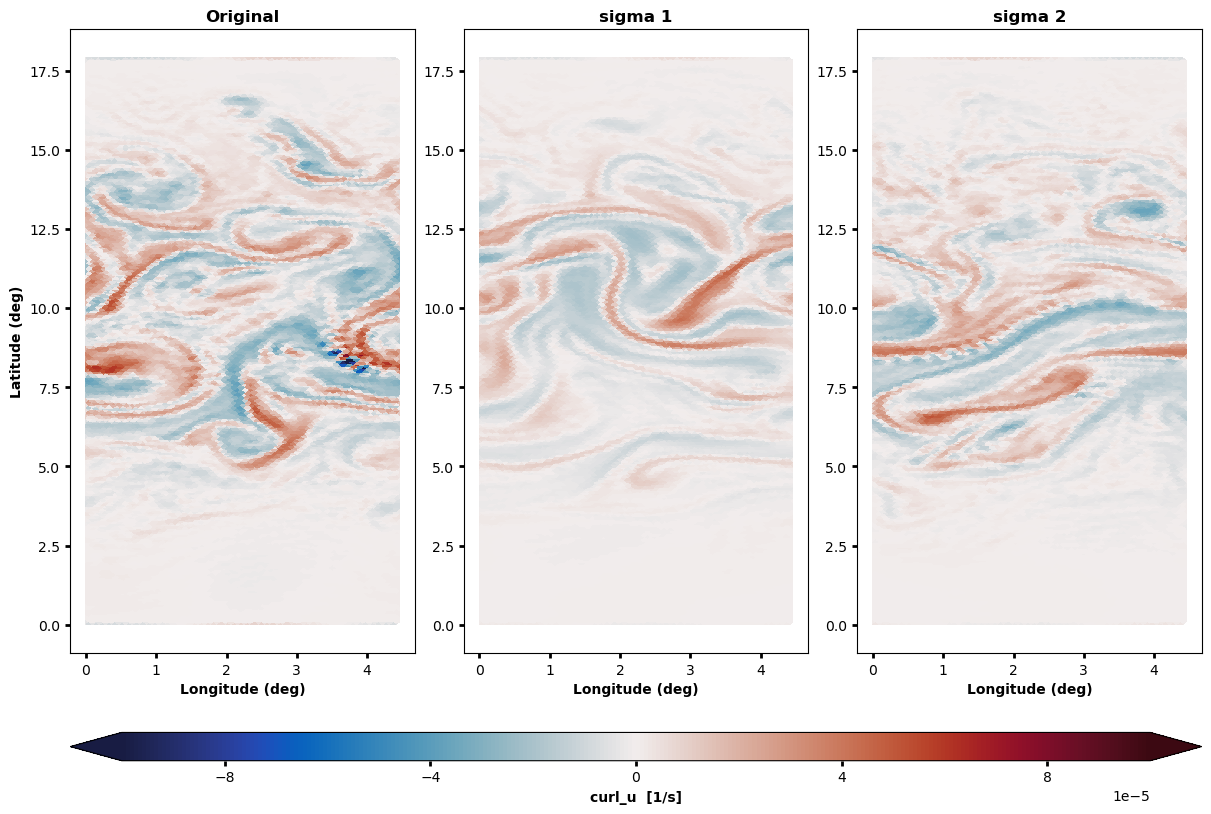

In [11]:
data_list_fesom = [data_fesom, data_fesom_sig1, data_fesom_sig2]
title_list = ['Original', 'sigma 1', 'sigma 2' ]

plot_unstructured_fesom_multiple(
    dobj_data_list= data_list_fesom, 
    title_list = title_list,
    meshdiag=ds_mesh,
    meshpath=meshfiles,
    str_ids=['curl_u', 'curl_u', 'curl_u'], 
    time=7665,
    level=0,
    vmin=-1e-4,
    vmax=1e-4,
    save_as='unstructured_fesom_half.png'
)

**2.2. structured grid**

In [12]:
from plotting_functions import plot_structured_fesom_multiple

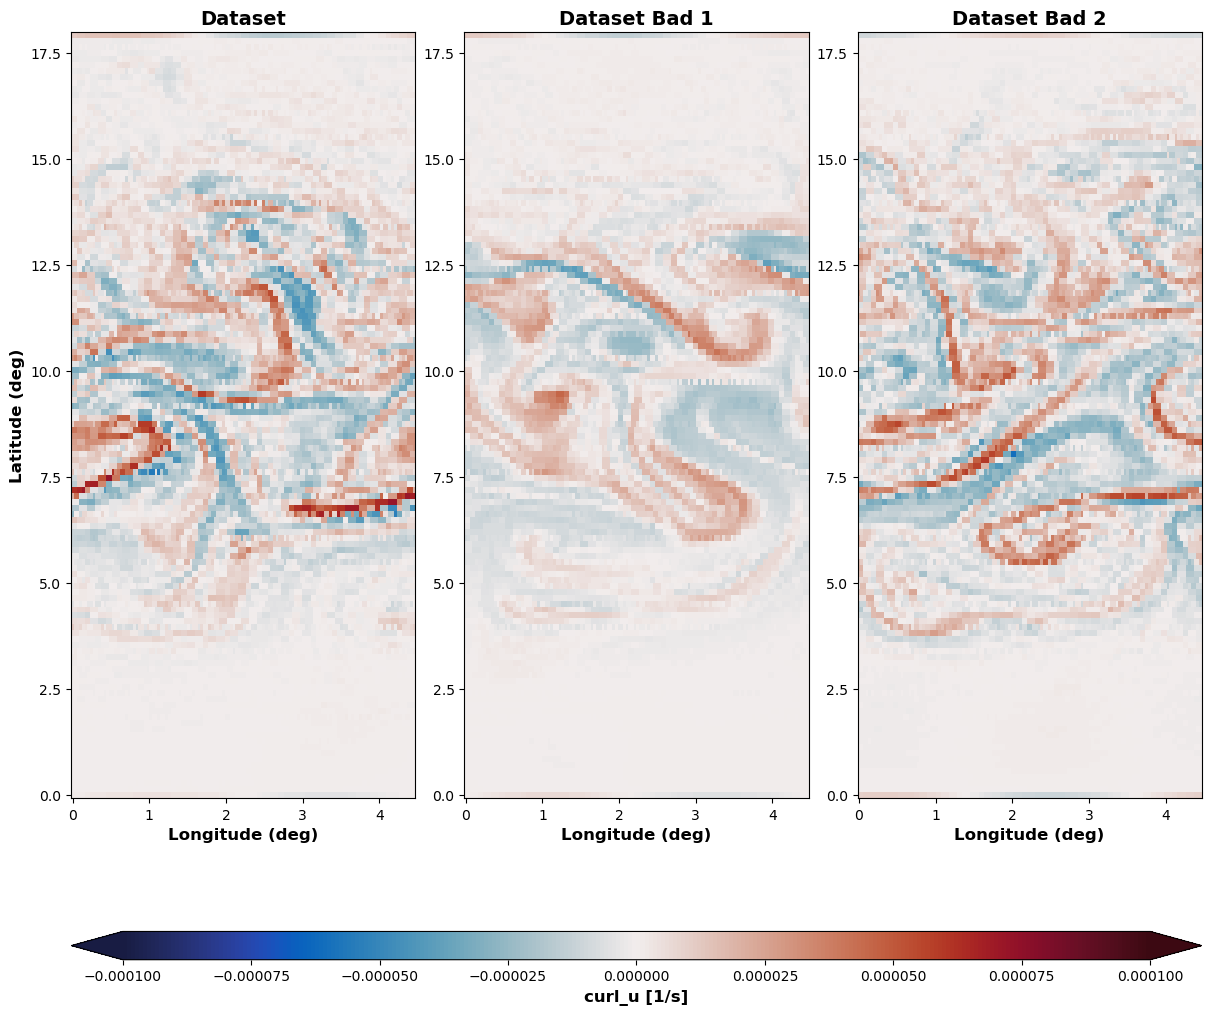

In [13]:
dataset_list = [dataset, dataset_bad1, dataset_bad2]
titles = ['Dataset', 'Dataset Bad 1', 'Dataset Bad 2']

# Call the function to plot
plot_structured_fesom_multiple(
    dataset_list=dataset_list,
    titles=titles,
    var_name='curl_u',
    time_index=-1,  # Last time step
    level_index=0,  # Surface level
    vmin=-1e-4,
    vmax=1e-4,
    save_as='structured_fesom_plot_3.png'  
)

#### 3. Neural Network

#### Select Time Steps

In [14]:
t = np.arange(0,len(dataset.time),50)

# t = np.arange(0,len(dataset.time),2)

In [15]:
t 

array([    0,    50,   100,   150,   200,   250,   300,   350,   400,
         450,   500,   550,   600,   650,   700,   750,   800,   850,
         900,   950,  1000,  1050,  1100,  1150,  1200,  1250,  1300,
        1350,  1400,  1450,  1500,  1550,  1600,  1650,  1700,  1750,
        1800,  1850,  1900,  1950,  2000,  2050,  2100,  2150,  2200,
        2250,  2300,  2350,  2400,  2450,  2500,  2550,  2600,  2650,
        2700,  2750,  2800,  2850,  2900,  2950,  3000,  3050,  3100,
        3150,  3200,  3250,  3300,  3350,  3400,  3450,  3500,  3550,
        3600,  3650,  3700,  3750,  3800,  3850,  3900,  3950,  4000,
        4050,  4100,  4150,  4200,  4250,  4300,  4350,  4400,  4450,
        4500,  4550,  4600,  4650,  4700,  4750,  4800,  4850,  4900,
        4950,  5000,  5050,  5100,  5150,  5200,  5250,  5300,  5350,
        5400,  5450,  5500,  5550,  5600,  5650,  5700,  5750,  5800,
        5850,  5900,  5950,  6000,  6050,  6100,  6150,  6200,  6250,
        6300,  6350,

In [16]:
dataset_sel = dataset.curl_u.isel(nz1=0, time=t)

# dataset_sel = dataset.u.isel(nz1=0, n3 = 0, time=t)

#### Load NN



In [17]:
dataset_reshaped = np.expand_dims(dataset_sel, axis=-1)

In [18]:
dataset_reshaped.shape

(307, 128, 128, 1)

In [19]:
dataset = dataset_reshaped

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
# import tensorflow_datasets as tfds
import tree

import matplotlib.image as mpimg
import scipy.stats as stats
import matplotlib.pyplot as pl

from sklearn.model_selection import train_test_split

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

2024-12-18 11:08:33.447306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version 2.16.2
Sonnet version 2.0.2


In [21]:
tf.keras.backend.set_floatx('float32')

In [22]:
def norm_train(x,min_x,max_x):
  return (x-min_x)/(max_x-min_x)-0.5
  #-0.5 0.5

In [23]:
# dataset_bad = norm_train(dataset_bad,dataset_bad.min(),dataset_bad.max())

In [24]:
nx = dataset.shape[1]

In [25]:
# normalize data
dataset =norm_train(dataset,dataset.min(),dataset.max())

# split train/val/test
train_data_dict, test_data_dict = train_test_split(dataset, test_size=0.15)
test_data_dict, valid_data_dict = train_test_split(test_data_dict, test_size=0.05)

In [26]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  #images = data_dict['image']
  #data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

#train_data_variance = np.var(train_data_dict['image'] / 255.0)
train_data_variance = np.var(train_data_dict )

print('train data variance: %s' % train_data_variance)

#This does nothing because it was orginally requried to convert images into float32

train data variance: 0.0013306234


In [27]:
train_data_dict.shape

(260, 128, 128, 1)

In [28]:
# class ResidualStack(snt.Module):
#   def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
#                name=None):
#     super(ResidualStack, self).__init__(name=name)
#     self._num_hiddens = num_hiddens
#     self._num_residual_layers = num_residual_layers
#     self._num_residual_hiddens = num_residual_hiddens

#     self._layers = []
#     for i in range(num_residual_layers):
#       conv3 = snt.Conv2D(
#           output_channels=num_residual_hiddens,
#           kernel_shape=(3, 3),
#           stride=(1, 1),
#           name="res3x3_%d" % i)
#       conv1 = snt.Conv2D(
#           output_channels=num_hiddens,
#           kernel_shape=(1, 1),
#           stride=(1, 1),
#           name="res1x1_%d" % i)
#       self._layers.append((conv3, conv1))

#   def __call__(self, inputs):
#     h = inputs
#     for conv3, conv1 in self._layers:
#       conv3_out = conv3(tf.nn.relu(h))
#       conv1_out = conv1(tf.nn.relu(conv3_out))
#       h += conv1_out
#     return tf.nn.relu(h)  # Resnet V1 style

class ResidualStack(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, name=None):
        super(ResidualStack, self).__init__(name=name)
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        # Initialize the layers in separate attributes using a loop
        self._layers = []
        for i in range(num_residual_layers):
            setattr(self, f"conv3_{i}", snt.Conv2D(
                output_channels=num_residual_hiddens,
                kernel_shape=(3, 3),
                stride=(1, 1),
                name=f"res3x3_{i}"
            ))
            setattr(self, f"conv1_{i}", snt.Conv2D(
                output_channels=num_hiddens,
                kernel_shape=(1, 1),
                stride=(1, 1),
                name=f"res1x1_{i}"
            ))
            self._layers.append((f"conv3_{i}", f"conv1_{i}"))  # Store layer names as identifiers

    def __call__(self, inputs):
        h = inputs
        for conv3_name, conv1_name in self._layers:
            conv3 = getattr(self, conv3_name)
            conv1 = getattr(self, conv1_name)
            conv3_out = conv3(tf.nn.relu(h))
            conv1_out = conv1(tf.nn.relu(conv3_out))
            h += conv1_out
        return tf.nn.relu(h)


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")

  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon


class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1,
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

In [ ]:
# Set hyper-parameters.
batch_size = nx
image_size = nx

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data, is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):

  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

100 train loss: 1.550420 recon_error: 1.550 perplexity: 2.794 vqvae loss: 0.000


### Save Model

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None, nx,nx,1])])
def inference(x):
  return model(x, is_training = False)

to_save = snt.Module()
to_save.inference = inference
# to_save.train_losses = train_losses
to_save.all_variables = list(model.variables)
tf.saved_model.save(to_save, "example_saved_model")

### Load Model

In [ ]:
nx = 64;

loaded = tf.saved_model.load("example_saved_model")

# Use the inference method. Note this doesn't run the Python code from `to_save`
# but instead uses the TensorFlow Graph that is part of the saved model.
loaded.inference(tf.ones([1, nx,nx,1]))

# The all_variables property can be used to retrieve the restored variables.
assert len(loaded.all_variables) > 0

### Test Model

In [ ]:
test = loaded.inference(tf.ones([1, nx,nx,1]))
test['x_recon']
test['z']

When using loaded model set is_taining = True to False

## Plots



### Plot Losses

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('losses')

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')
plt.ylim([0, 0.1])

plt.tight_layout()

plt.savefig('losses_zoom')

### Evaluate Model Performance

In [ ]:
def rmse(a,b):
  return np.sqrt(np.mean((a-b)**2))

In [ ]:
out = model(dataset, is_training = True)
rec_good= out['x_recon'].numpy()

In [ ]:
rec_good_1 = rec_good[100,:,:,0]

In [ ]:
dataset_1 = dataset[100,:,:,0]

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(dataset_1)
plt.colorbar()
plt.title("Original Good")
plt.subplot(132)
plt.imshow(rec_good_1)
plt.colorbar()
plt.title("Reconstructed Good")
plt.subplot(133)
plt.imshow(dataset_1 - rec_good_1)
plt.colorbar()
plt.title("Difference")
plt.savefig("FESOM_good")

In [ ]:
rmse(dataset_1, rec_good_1)